In [2]:
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as pnp
import jax
from jax import numpy as jnp
import optax

pnp.random.seed(42)

dev = qml.device('default.qubit', wires=2)

In [3]:
def S(x):
    qml.AngleEmbedding( x, wires=[0,1],rotation='Z')

In [4]:
def W(params):
    qml.StronglyEntanglingLayers(params, wires=[0,1])

In [5]:
@qml.qnode(dev,interface="jax")
def quantum_neural_network(params, x):
    layers=len(params[:,0,0])-1
    n_wires=len(params[0,:,0])
    n_params_rot=len(params[0,0,:])
    for i in range(layers):
      W(params[i,:,:].reshape(1,n_wires,n_params_rot))
      S(x)
    W(params[-1,:,:].reshape(1,n_wires,n_params_rot))

    return qml.expval(qml.PauliZ(wires=0)@qml.PauliZ(wires=1))

In [6]:
def target_function(x):
    f=1/2*(x[0]**2+x[1]**2)
    return f

In [7]:
x1_min=-1
x1_max=1
x2_min=-1
x2_max=1
num_samples=30

In [8]:
x1_train=pnp.linspace(x1_min,x1_max, num_samples)
x2_train=pnp.linspace(x2_min,x2_max, num_samples)
x1_mesh,x2_mesh=pnp.meshgrid(x1_train, x2_train)

In [9]:
x_train=pnp.stack((x1_mesh.flatten(), x2_mesh.flatten()), axis=1)
y_train = target_function([x1_mesh,x2_mesh]).reshape(-1,1)
# Let's take a look at how they look like
print("x_train:\n", x_train[:5])
print("y_train:\n", y_train[:5])

x_train:
 [[-1.         -1.        ]
 [-0.93103448 -1.        ]
 [-0.86206897 -1.        ]
 [-0.79310345 -1.        ]
 [-0.72413793 -1.        ]]
y_train:
 [[1.        ]
 [0.9334126 ]
 [0.87158145]
 [0.81450654]
 [0.76218787]]


Circuit optimization

In [10]:
@jax.jit
def mse(params,x,targets):
    # We compute the mean square error between the target function and the quantum circuit to quantify the quality of our estimator
    return (quantum_neural_network(params,x)-jnp.array(targets))**2
@jax.jit
def loss_fn(params, x,targets):
    # We define the loss function to feed our optimizer
    mse_pred = jax.vmap(mse,in_axes=(None, 0,0))(params,x,targets)
    loss = jnp.mean(mse_pred)
    return loss

In [11]:
opt = optax.adam(learning_rate=0.05)
max_steps=300

@jax.jit
def update_step_jit(i, args):
    # We loop over this function to optimize the trainable parameters
    params, opt_state, data, targets, print_training = args
    loss_val, grads = jax.value_and_grad(loss_fn)(params, data, targets)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

    def print_fn():
        jax.debug.print("Step: {i}  Loss: {loss_val}", i=i, loss_val=loss_val)
    # if print_training=True, print the loss every 50 steps
    jax.lax.cond((jnp.mod(i, 50) == 0 ) & print_training, print_fn, lambda: None)
    return (params, opt_state, data, targets, print_training)

@jax.jit
def optimization_jit(params, data, targets, print_training=False):
    opt_state = opt.init(params)
    args = (params, opt_state, jnp.asarray(data), targets, print_training)
    # We loop over update_step_jit max_steps iterations to optimize the parameters
    (params, opt_state, _, _, _) = jax.lax.fori_loop(0, max_steps+1, update_step_jit, args)
    return params

In [12]:
wires=2
layers=4
params_shape = qml.StronglyEntanglingLayers.shape(n_layers=layers+1,n_wires=wires)
params=pnp.random.default_rng().random(size=params_shape)
best_params=optimization_jit(params, x_train, jnp.array(y_train), print_training=True)

Step: 0  Loss: 0.28491103649139404


In [13]:
def evaluate(params, data):
    y_pred = jax.vmap(quantum_neural_network, in_axes=(None, 0))(params, data)
    return y_pred
y_predictions=evaluate(best_params,x_train)

Step: 50  Loss: 0.02257339097559452
Step: 100  Loss: 0.0027265565004199743
Step: 150  Loss: 0.0017511614132672548
Step: 200  Loss: 0.00153361726552248
Step: 250  Loss: 0.0013257665559649467
Step: 300  Loss: 0.0011489598546177149


In [14]:
from sklearn.metrics import r2_score
r2 = round(float(r2_score(y_train, y_predictions)),3)
print("R^2 Score:", r2)

R^2 Score: 0.977


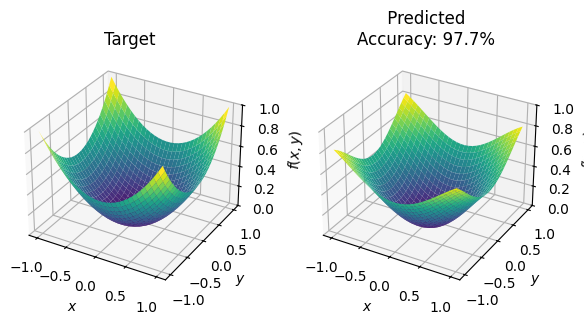

In [15]:
fig = plt.figure()
# Target function
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(x1_mesh,x2_mesh, y_train.reshape(x1_mesh.shape), cmap='viridis')
ax1.set_zlim(0,1)
ax1.set_xlabel('$x$',fontsize=10)
ax1.set_ylabel('$y$',fontsize=10)
ax1.set_zlabel('$f(x,y)$',fontsize=10)
ax1.set_title('Target ')

# Predictions
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(x1_mesh,x2_mesh, y_predictions.reshape(x1_mesh.shape), cmap='viridis')
ax2.set_zlim(0,1)
ax2.set_xlabel('$x$',fontsize=10)
ax2.set_ylabel('$y$',fontsize=10)
ax2.set_zlabel('$f(x,y)$',fontsize=10)
ax2.set_title(f' Predicted \nAccuracy: {round(r2*100,3)}%')

# Show the plot
plt.tight_layout(pad=3.7)